<a href="https://colab.research.google.com/github/emilyh-301/COMP520_BertMovieModel/blob/main/BERT_Movie_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
########################################################
# Installs
########################################################
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-wovnzjut
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-wovnzjut
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3 MB 4.1 MB/s 
     |████████████████████████████████| 61 kB 567 kB/s 
     |████████████████████████████████| 596 kB 49.3 MB/s 
     |████████████████████████████████| 895 kB 42.5 MB/s 
  Created wheel for transformers: filename=transformers-4.13.0.dev0-py3-none-any.whl size=3320810 sha256=ba06582043a5627ef04592e8d0772288814af3bf5a168db1cca5ce7de3612986
  Stored in directory: /tmp/pip-ephem-wheel-cache-rhqy3s1h/wheels/90/a5/44/6bcd83827c8a60628c5ad602f429cd5076bcce5f2a90054947
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [ ]:
########################################################
# Import
########################################################
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig
import tensorflow as tf
import pandas as pd
import json
import gc
import numpy as np
import os
import torch
import re
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
########################################################
# Set Up
########################################################
print(torch.cuda.is_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
from google.colab import drive
drive.mount('/content/drive')

True
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive


In [ ]:
########################################################
# Import Dataset
########################################################
##change path accordingly
train_data_path='drive/MyDrive/Movie_Data/IMDbMoviesCleaned.csv'
data = pd.read_csv(train_data_path)

print(data.shape)
data.head()

(83740, 29)


,imdb_title_id,title,original_title,description,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Reality-TV,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0000009,Miss Jerry,Miss Jerry,The adventures of a female reporter in the 1890s.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,True story of notorious Australian outlaw Ned ...,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,tt0001892,Den sorte drøm,Den sorte drøm,Two men of high rank are both wooing the beaut...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,tt0002101,Cleopatra,Cleopatra,The fabled queen of Egypt's affair with Roman ...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,tt0002130,L'Inferno,L'Inferno,Loosely adapted from Dante's Divine Comedy and...,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_texts = data["description"].to_list() # Datasets - Descriptions
print(data_texts[600])

Two American soldiers are captured by the Germans on the Western Front during World War One and escape a POW camp only to stumble into further life-threatening adventures when they come across an Arabian king's daughter while on the lam.


In [ ]:
#Cleaning the data
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [ ]:
data["clean_desc"] = data["description"].apply(lambda x: clean_text(x))
data_texts = data["clean_desc"].to_list() # Datasets - Descriptions

In [ ]:
print(data_texts[600])

two american soldiers are captured by the germans on the western front during world war one and escape a pow camp only to stumble into further life threatening adventures when they come across an arabian kings daughter while on the lam


In [ ]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

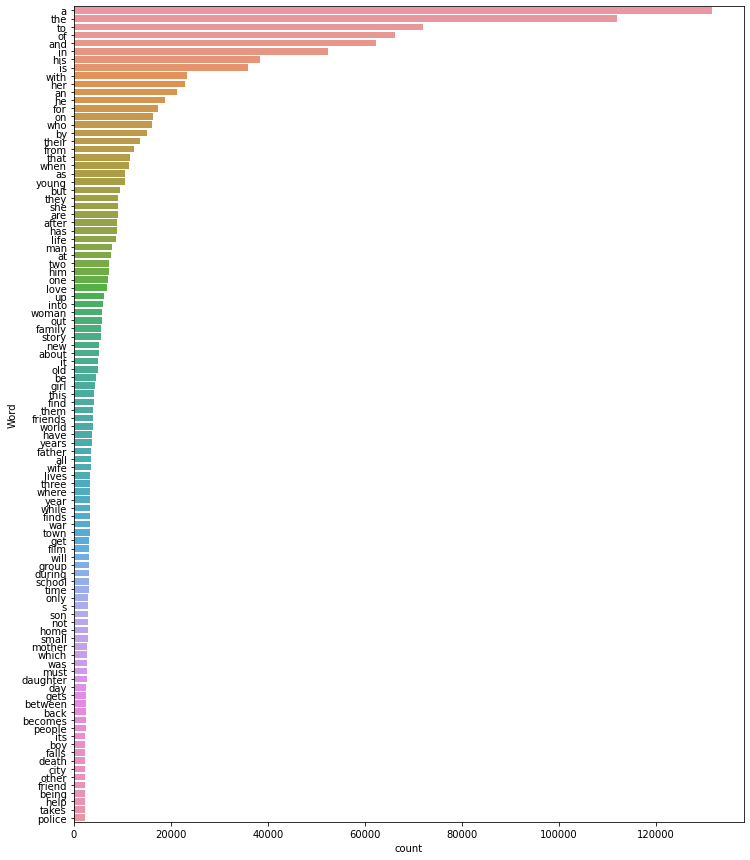

In [ ]:
# print 100 most frequent words 
freq_words(data["clean_desc"], 100)

In [ ]:
movie_labels = data[["Action","Comedy","Crime","Drama","Horror","Romance"]] #update - add labels
movie_labels.head()

,Action,Comedy,Crime,Drama,Horror,Romance
0,0,0,0,0,0,1
1,0,0,1,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


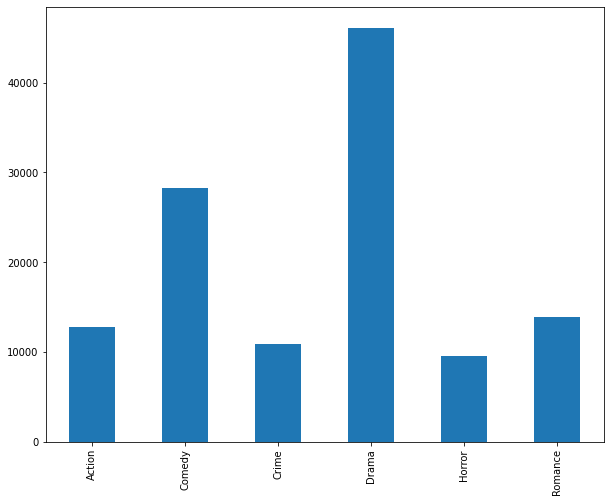

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

movie_labels.sum(axis=0).plot.bar()

In [ ]:
########################################################
# Action Model
########################################################

In [ ]:
 #Action Label
data_labels = data["Action"].to_list()
print(data_labels[0])

0


In [ ]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

In [ ]:
#Action Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
config = DistilBertConfig(num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=7, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))


save_directory = "drive/MyDrive/Movie_Data/action_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Epoch 1/7
4187/4187 [==============================] - 490s 115ms/step - loss: 0.3095 - accuracy: 0.8723 - val_loss: 0.2967 - val_accuracy: 0.8796
Epoch 2/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.2366 - accuracy: 0.9010 - val_loss: 0.3635 - val_accuracy: 0.8465
Epoch 3/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.1496 - accuracy: 0.9421 - val_loss: 0.3888 - val_accuracy: 0.8671
Epoch 4/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.0844 - accuracy: 0.9709 - val_loss: 0.4937 - val_accuracy: 0.8574
Epoch 5/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.0527 - accuracy: 0.9835 - val_loss: 0.4790 - val_accuracy: 0.8611
Epoch 6/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.0425 - accuracy: 0.9875 - val_loss: 0.6133 - val_accuracy: 0.8568
Epoch 7/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.0337 - accuracy: 0.9905 - val_loss: 0

('drive/MyDrive/Movie_Data/action_model/tokenizer_config.json',
 'drive/MyDrive/Movie_Data/action_model/special_tokens_map.json',
 'drive/MyDrive/Movie_Data/action_model/vocab.txt',
 'drive/MyDrive/Movie_Data/action_model/added_tokens.json')

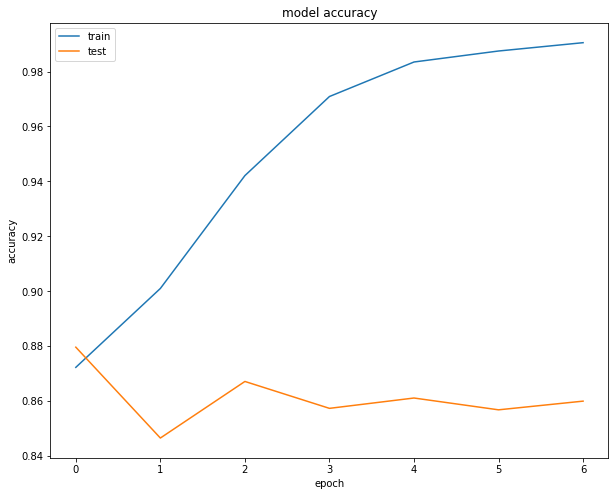

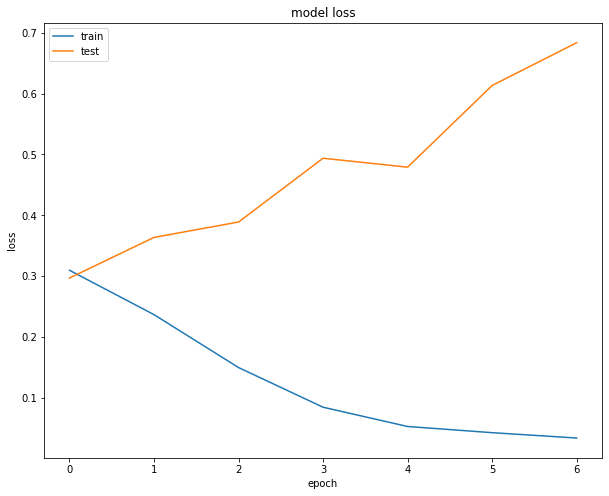

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
########################################################
# Comedy Model
########################################################

In [ ]:
 #Comedy Label
data_labels = data["Comedy"].to_list()
print(data_labels[0])

0


In [ ]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

In [ ]:
#Comedy Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
config = DistilBertConfig(num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=7, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))


save_directory = "drive/MyDrive/Movie_Data/comedy_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Epoch 1/7
4187/4187 [==============================] - 486s 114ms/step - loss: 0.5122 - accuracy: 0.7503 - val_loss: 0.4975 - val_accuracy: 0.7560
Epoch 2/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.3899 - accuracy: 0.8291 - val_loss: 0.5506 - val_accuracy: 0.7511
Epoch 3/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.2235 - accuracy: 0.9140 - val_loss: 0.6830 - val_accuracy: 0.7490
Epoch 4/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.1228 - accuracy: 0.9566 - val_loss: 0.9729 - val_accuracy: 0.7459
Epoch 5/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.0810 - accuracy: 0.9727 - val_loss: 1.0632 - val_accuracy: 0.7412
Epoch 6/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.0610 - accuracy: 0.9796 - val_loss: 1.1870 - val_accuracy: 0.7383
Epoch 7/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.0510 - accuracy: 0.9833 - val_loss: 1

('drive/MyDrive/Movie_Data/comedy_model/tokenizer_config.json',
 'drive/MyDrive/Movie_Data/comedy_model/special_tokens_map.json',
 'drive/MyDrive/Movie_Data/comedy_model/vocab.txt',
 'drive/MyDrive/Movie_Data/comedy_model/added_tokens.json')

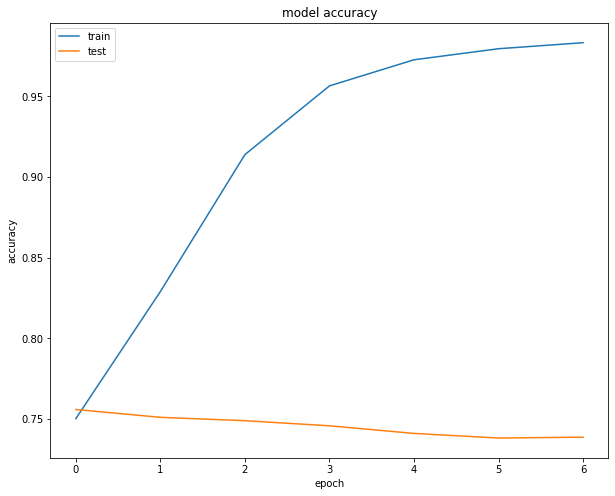

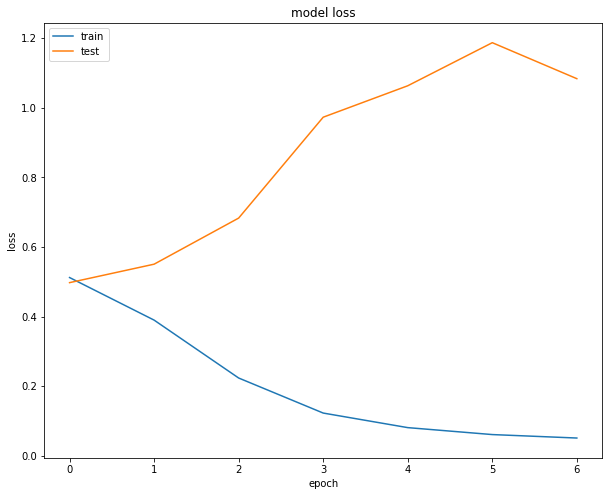

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
########################################################
# Crime Model
########################################################

In [ ]:
 #Crime Label
data_labels = data["Crime"].to_list()
print(data_labels[0])

0


In [ ]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

In [ ]:
#Crime Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
config = DistilBertConfig(num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_59', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=7, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))


save_directory = "drive/MyDrive/Movie_Data/crime_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Epoch 1/7
4187/4187 [==============================] - 487s 115ms/step - loss: 0.2870 - accuracy: 0.8816 - val_loss: 0.2742 - val_accuracy: 0.8868
Epoch 2/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.2326 - accuracy: 0.9042 - val_loss: 0.2825 - val_accuracy: 0.8882
Epoch 3/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.1717 - accuracy: 0.9310 - val_loss: 0.3361 - val_accuracy: 0.8759
Epoch 4/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.1148 - accuracy: 0.9585 - val_loss: 0.4088 - val_accuracy: 0.8699
Epoch 5/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.0733 - accuracy: 0.9752 - val_loss: 0.5326 - val_accuracy: 0.8693
Epoch 6/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.0518 - accuracy: 0.9837 - val_loss: 0.5765 - val_accuracy: 0.8627
Epoch 7/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.0378 - accuracy: 0.9888 - val_loss: 0

('drive/MyDrive/Movie_Data/crime_model/tokenizer_config.json',
 'drive/MyDrive/Movie_Data/crime_model/special_tokens_map.json',
 'drive/MyDrive/Movie_Data/crime_model/vocab.txt',
 'drive/MyDrive/Movie_Data/crime_model/added_tokens.json')

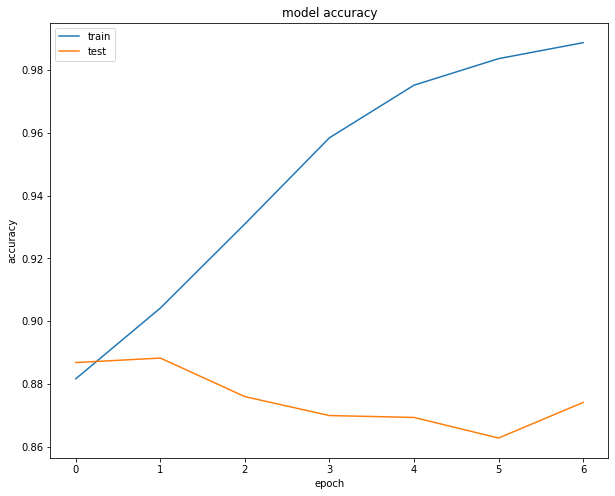

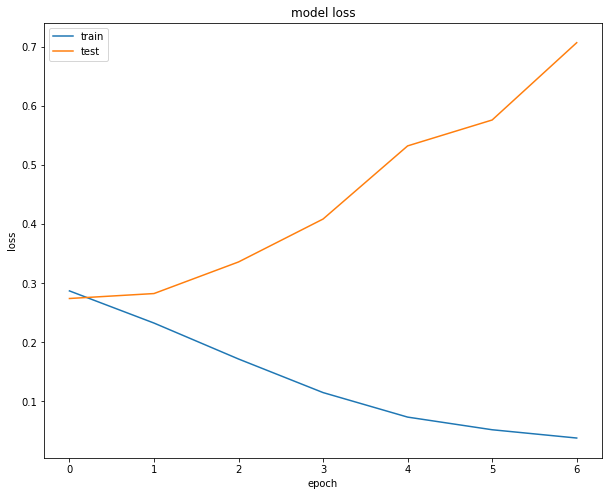

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
########################################################
# Drama Model
########################################################

In [ ]:
 #Drama Label
data_labels = data["Drama"].to_list()
print(data_labels[0])

0


In [ ]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

In [ ]:
#Drama Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_79', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
config = DistilBertConfig(num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_99', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_99 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=7, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))


save_directory = "drive/MyDrive/Movie_Data/drama_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Epoch 1/7
4187/4187 [==============================] - 487s 115ms/step - loss: 0.5765 - accuracy: 0.6981 - val_loss: 0.5583 - val_accuracy: 0.7124
Epoch 2/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.4677 - accuracy: 0.7809 - val_loss: 0.6217 - val_accuracy: 0.7036
Epoch 3/7
4187/4187 [==============================] - 478s 114ms/step - loss: 0.3036 - accuracy: 0.8749 - val_loss: 0.7435 - val_accuracy: 0.6936
Epoch 4/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.1669 - accuracy: 0.9380 - val_loss: 0.8636 - val_accuracy: 0.6837
Epoch 5/7
4187/4187 [==============================] - 480s 115ms/step - loss: 0.1079 - accuracy: 0.9618 - val_loss: 0.9814 - val_accuracy: 0.6857
Epoch 6/7
4187/4187 [==============================] - 480s 115ms/step - loss: 0.0779 - accuracy: 0.9726 - val_loss: 1.2518 - val_accuracy: 0.6855
Epoch 7/7
4187/4187 [==============================] - 480s 115ms/step - loss: 0.0647 - accuracy: 0.9781 - val_loss: 1

('drive/MyDrive/Movie_Data/drama_model/tokenizer_config.json',
 'drive/MyDrive/Movie_Data/drama_model/special_tokens_map.json',
 'drive/MyDrive/Movie_Data/drama_model/vocab.txt',
 'drive/MyDrive/Movie_Data/drama_model/added_tokens.json')

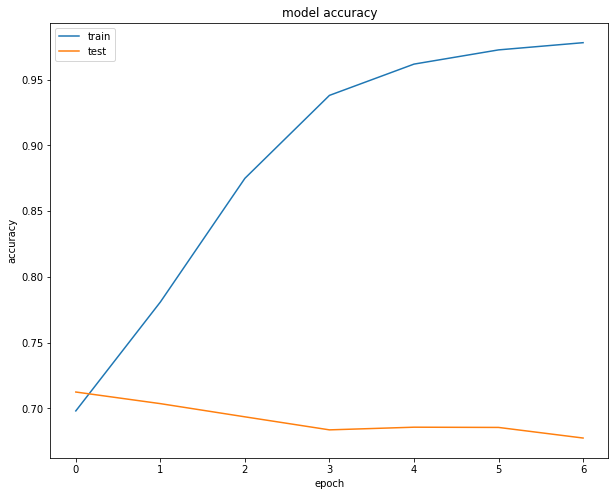

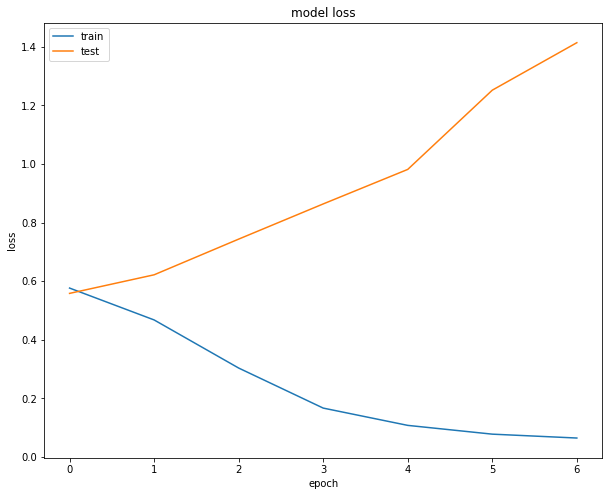

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
########################################################
# Horror Model
########################################################

In [ ]:
 #Horror Label
data_labels = data["Horror"].to_list()
print(data_labels[0])

0


In [ ]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

In [ ]:
#Horror Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
config = DistilBertConfig(num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_119', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [ ]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_119 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=7, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))


save_directory = "drive/MyDrive/Movie_Data/horror_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Epoch 1/7
4187/4187 [==============================] - 489s 115ms/step - loss: 0.2053 - accuracy: 0.9222 - val_loss: 0.1895 - val_accuracy: 0.9295
Epoch 2/7
4187/4187 [==============================] - 480s 115ms/step - loss: 0.1363 - accuracy: 0.9488 - val_loss: 0.2146 - val_accuracy: 0.9174
Epoch 3/7
4187/4187 [==============================] - 479s 115ms/step - loss: 0.0777 - accuracy: 0.9736 - val_loss: 0.3129 - val_accuracy: 0.9162
Epoch 4/7
4187/4187 [==============================] - 482s 115ms/step - loss: 0.0473 - accuracy: 0.9856 - val_loss: 0.3471 - val_accuracy: 0.9206
Epoch 5/7
4187/4187 [==============================] - 481s 115ms/step - loss: 0.0334 - accuracy: 0.9903 - val_loss: 0.3959 - val_accuracy: 0.9171
Epoch 6/7
4187/4187 [==============================] - 480s 115ms/step - loss: 0.0288 - accuracy: 0.9915 - val_loss: 0.3576 - val_accuracy: 0.9165
Epoch 7/7
4187/4187 [==============================] - 480s 115ms/step - loss: 0.0262 - accuracy: 0.9926 - val_loss: 0

('drive/MyDrive/Movie_Data/horror_model/tokenizer_config.json',
 'drive/MyDrive/Movie_Data/horror_model/special_tokens_map.json',
 'drive/MyDrive/Movie_Data/horror_model/vocab.txt',
 'drive/MyDrive/Movie_Data/horror_model/added_tokens.json')

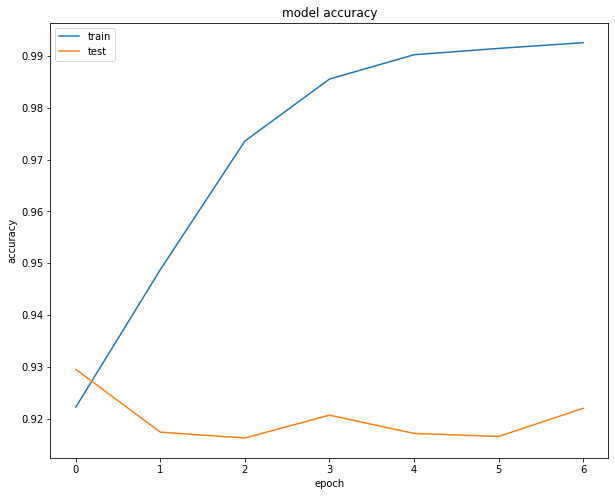

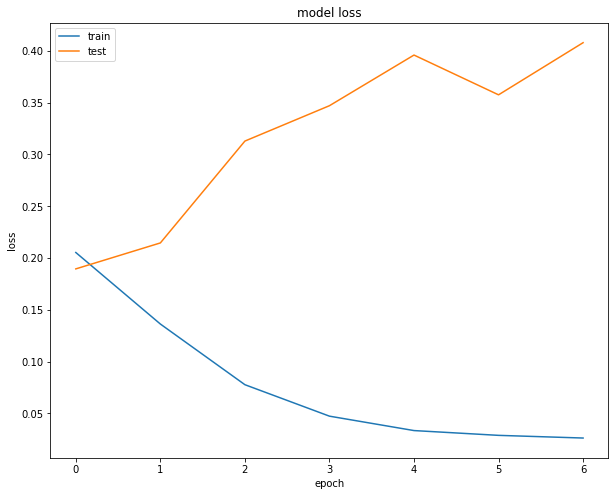

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
########################################################
# Romance Model
########################################################

In [ ]:
 #Romance Label
data_labels = data["Romance"].to_list()
print(data_labels[0])

1


In [ ]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

In [ ]:
#Romance Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
config = DistilBertConfig(num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_139', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [ ]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_139 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=7, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))


save_directory = "drive/MyDrive/Movie_Data/romance_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Epoch 1/7
4187/4187 [==============================] - 488s 115ms/step - loss: 0.3751 - accuracy: 0.8430 - val_loss: 0.3671 - val_accuracy: 0.8461
Epoch 2/7
4187/4187 [==============================] - 480s 115ms/step - loss: 0.3170 - accuracy: 0.8649 - val_loss: 0.3836 - val_accuracy: 0.8382
Epoch 3/7
4187/4187 [==============================] - 480s 115ms/step - loss: 0.2256 - accuracy: 0.9100 - val_loss: 0.5080 - val_accuracy: 0.8374
Epoch 4/7
4187/4187 [==============================] - 479s 115ms/step - loss: 0.1358 - accuracy: 0.9512 - val_loss: 0.6909 - val_accuracy: 0.8292
Epoch 5/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.0822 - accuracy: 0.9722 - val_loss: 0.6507 - val_accuracy: 0.8104
Epoch 6/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.0558 - accuracy: 0.9819 - val_loss: 0.7800 - val_accuracy: 0.8262
Epoch 7/7
4187/4187 [==============================] - 479s 114ms/step - loss: 0.0451 - accuracy: 0.9862 - val_loss: 0

('drive/MyDrive/Movie_Data/romance_model/tokenizer_config.json',
 'drive/MyDrive/Movie_Data/romance_model/special_tokens_map.json',
 'drive/MyDrive/Movie_Data/romance_model/vocab.txt',
 'drive/MyDrive/Movie_Data/romance_model/added_tokens.json')

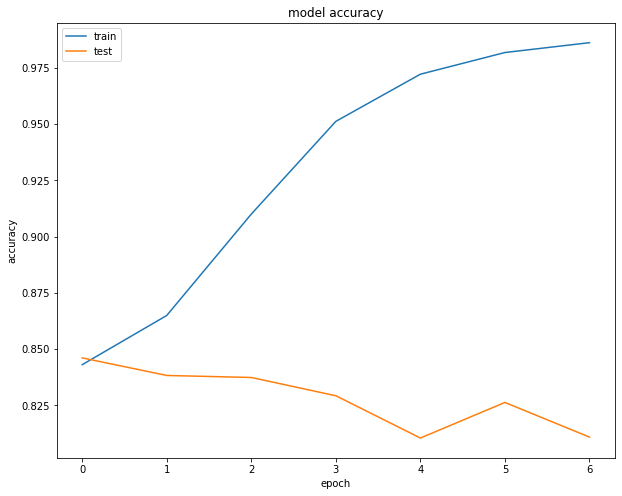

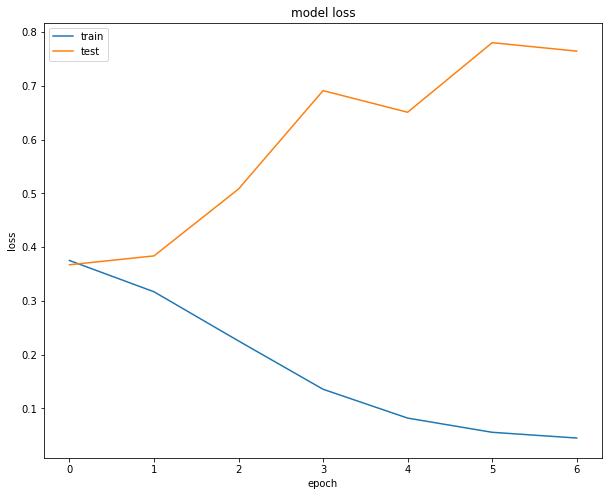

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import TFDistilBertForSequenceClassification

In [ ]:
########################################################
# Load the Models
########################################################
save_directory1 = "drive/MyDrive/Movie_Data/action_model"
loaded_tokenizer_pt1 = DistilBertTokenizer.from_pretrained(save_directory1)
loaded_model_pt1 = DistilBertForSequenceClassification.from_pretrained(save_directory1, from_tf=True)

save_directory2 = "drive/MyDrive/Movie_Data/comedy_model"
loaded_tokenizer_pt2 = DistilBertTokenizer.from_pretrained(save_directory2)
loaded_model_pt2 = DistilBertForSequenceClassification.from_pretrained(save_directory2, from_tf=True)

save_directory3 = "drive/MyDrive/Movie_Data/crime_model"
loaded_tokenizer_pt3 = DistilBertTokenizer.from_pretrained(save_directory3)
loaded_model_pt3 = DistilBertForSequenceClassification.from_pretrained(save_directory3, from_tf=True)

save_directory4 = "drive/MyDrive/Movie_Data/drama_model"
loaded_tokenizer_pt4 = DistilBertTokenizer.from_pretrained(save_directory4)
loaded_model_pt4 = DistilBertForSequenceClassification.from_pretrained(save_directory4, from_tf=True)

save_directory5 = "drive/MyDrive/Movie_Data/horror_model"
loaded_tokenizer_pt5 = DistilBertTokenizer.from_pretrained(save_directory5)
loaded_model_pt5 = DistilBertForSequenceClassification.from_pretrained(save_directory5, from_tf=True)

save_directory6 = "drive/MyDrive/Movie_Data/romance_model"
loaded_tokenizer_pt6 = DistilBertTokenizer.from_pretrained(save_directory6)
loaded_model_pt6 = DistilBertForSequenceClassification.from_pretrained(save_directory6, from_tf=True)

All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you ca

In [ ]:
########################################################
# Testing the Models
########################################################
movie_name = input("Name of movie to classify:\n")
test_text = input("Write a description:\n ")
#test_text = clean_text(input_text)
print(test_text)

Name of movie to classify:
Richard III
Write a description:
 Richard of Gloucester uses manipulation and murder to gain the English throne.
Richard of Gloucester uses manipulation and murder to gain the English throne.


In [ ]:
########################################################
# Predictions from the Models
########################################################
predict_input_pt1 = loaded_tokenizer_pt1.encode(test_text,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="pt")

output_pt1 = loaded_model_pt1(predict_input_pt1)[0]

predictions_value_pt1 = torch.argmax(output_pt1[0], dim=-1).item()

predict_input_pt2 = loaded_tokenizer_pt2.encode(test_text,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="pt")

output_pt2 = loaded_model_pt2(predict_input_pt2)[0]

predictions_value_pt2 = torch.argmax(output_pt2[0], dim=-1).item()

predict_input_pt3 = loaded_tokenizer_pt3.encode(test_text,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="pt")

output_pt3 = loaded_model_pt3(predict_input_pt3)[0]

predictions_value_pt3 = torch.argmax(output_pt3[0], dim=-1).item()

predict_input_pt4 = loaded_tokenizer_pt4.encode(test_text,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="pt")

output_pt4 = loaded_model_pt4(predict_input_pt4)[0]

predictions_value_pt4 = torch.argmax(output_pt4[0], dim=-1).item()

predict_input_pt5 = loaded_tokenizer_pt5.encode(test_text,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="pt")

output_pt5 = loaded_model_pt5(predict_input_pt5)[0]

predictions_value_pt5 = torch.argmax(output_pt5[0], dim=-1).item()

predict_input_pt6 = loaded_tokenizer_pt6.encode(test_text,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="pt")

output_pt6 = loaded_model_pt6(predict_input_pt6)[0]

predictions_value_pt6 = torch.argmax(output_pt6[0], dim=-1).item()


genre_prediction = [predictions_value_pt1, predictions_value_pt2, predictions_value_pt3, 
                    predictions_value_pt4, predictions_value_pt5, predictions_value_pt6]
print("Models have predicted a value of: ")
print(genre_prediction)

Models have predicted a value of: 
[0, 0, 0, 1, 0, 0]


In [ ]:
genre_names = []
if predictions_value_pt1 == 1:
    genre_names.append("Action")
if predictions_value_pt2 == 1:
    genre_names.append("Comedy")
if predictions_value_pt3 == 1:
    genre_names.append("Crime")
if predictions_value_pt4 == 1:
    genre_names.append("Drama")
if predictions_value_pt5 == 1:
    genre_names.append("Horror")
if predictions_value_pt6 == 1:
    genre_names.append("Romance")
    
print("The movie {} has been viewed as:".format(movie_name))
print(genre_names)

The movie Richard III has been viewed as:
['Drama']
